In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import toml
import glob

# Read config and prepare dataset

In [2]:
config = toml.load('config.toml')

In [3]:
save_folder = config['preprocess']['output_folder']
music_data = ''
# print(isinstance(music_data, str))
for data_path in glob.glob(save_folder + '/*.npy'):
    read = np.load(data_path)
    if isinstance(music_data,str):
        music_data = read
    else:
        music_data = np.append(music_data, read, axis=1)

# music_data = np.concatenate(music_data, axis = 1)


In [4]:
normalize = lambda x : (x - x.min()) / (x.max()-x.min())

In [5]:
#normalize the input.
music_data = np.abs(music_data)
music_data = librosa.amplitude_to_db(music_data)
music_data = normalize(music_data)

In [6]:
music_data.max()

1.0

In [7]:
# Data hyperparameters
seq_length = 64
window_stride = 3

# Learning hyperparameters
learning_rate = 0.005
batch_size = 120
input_size = music_data.shape[0]
ds_size = music_data.shape[1]

# Generation hyperparameters
temperature = 0.2 # 0.2 - 1 
num_predictions = 120
# prediction_sample_size = 120


# Create the training dataset

In [8]:
music_ds = tf.data.Dataset.from_tensor_slices(music_data.T)
music_ds.element_spec

2022-02-02 01:54:01.064350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 01:54:01.113331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 01:54:01.113545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 01:54:01.114221: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

TensorSpec(shape=(1025,), dtype=tf.float32, name=None)

In [9]:
def create_training_sequences(dataset: tf.data.Dataset, seq_length: int) -> tf.data.Dataset:
    """Create training sequences and respective labels for training."""
    seq_length += 1
    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=window_stride,
                                drop_remainder=True)
    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)


    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        target = sequences[-1]
        return inputs, target

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)



In [10]:
seq_ds = create_training_sequences(music_ds, seq_length)
seq_ds.element_spec

(TensorSpec(shape=(64, 1025), dtype=tf.float32, name=None),
 TensorSpec(shape=(1025,), dtype=tf.float32, name=None))

In [11]:
buffer_size = ds_size - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE)
            )



In [12]:
train_ds.element_spec

(TensorSpec(shape=(120, 64, 1025), dtype=tf.float32, name=None),
 TensorSpec(shape=(120, 1025), dtype=tf.float32, name=None))

# Create and train the model.

In [13]:

halved_inputsize = int(input_size * 0.5)
input_shape = (seq_length, input_size)
model = keras.Sequential(
    # [
#  tf.keras.Input(input_shape),
#  tf.keras.layers.AveragePooling1D()(inputs),
#  tf.keras.layers.MultiHeadAttention(num_heads=24, key_dim=64)(input_pool,input_pool), # Self-attention,
#  tf.keras.layers.add([input_pool, input_attention]),
#  tf.keras.layers.Normalization()(input_add),
#  tf.keras.layers.Dense(halved_inputsize)(input_pool),
#  tf.keras.layers.GaussianNoise(.1)(input_pool),
#  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(halved_inputsize, return_sequences=True))(input_final),
#  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(halved_inputsize, return_sequences=True))(encoding_l1),
#  tf.keras.layers.MultiHeadAttention(num_heads=24, key_dim=64)(encoding_l2,encoding_l2), # Self-attention,
#  tf.keras.layers.add([encoding_attention , encoding_l2]),
#  tf.keras.layers.Normalization()(encoding_add),
#  tf.keras.layers.LSTM(halved_inputsize, return_sequences=True)(encoding_final),
#  tf.keras.layers.LSTM(halved_inputsize, return_sequences=False)(encoding_l1),
#  tf.keras.layers.Dense(input_size)(decoding_l2),
# ]
)
inputs = tf.keras.Input(input_shape)
input_pool = tf.keras.layers.AveragePooling1D()(inputs)
input_attention = tf.keras.layers.MultiHeadAttention(num_heads=24, key_dim=64)(input_pool,input_pool) # Self-attention
input_add = tf.keras.layers.add([input_pool, input_attention])
input_final = tf.keras.layers.Normalization()(input_add)
# input_encoder = tf.keras.layers.Dense(halved_inputsize)(input_pool)
# input_rand = tf.keras.layers.GaussianNoise(.1)(input_pool)
encoding_l1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(halved_inputsize, return_sequences=True))(input_final)
encoding_l2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(halved_inputsize//2, return_sequences=True))(encoding_l1)
encoding_attention = tf.keras.layers.MultiHeadAttention(num_heads=24, key_dim=64)(encoding_l2,encoding_l2) # Self-attention
encoding_add = tf.keras.layers.add([encoding_attention , encoding_l2])
encoding_final = tf.keras.layers.Normalization()(encoding_add)
decoding_l1 = tf.keras.layers.LSTM(halved_inputsize, return_sequences=True)(encoding_final)
decoding_l2 = tf.keras.layers.LSTM(halved_inputsize, return_sequences=False)(encoding_l1)
output = tf.keras.layers.Dense(input_size)(decoding_l2)

model = tf.keras.Model(inputs, output)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 1025)]   0           []                               
                                                                                                  
 average_pooling1d (AveragePool  (None, 32, 1025)    0           ['input_1[0][0]']                
 ing1D)                                                                                           
                                                                                                  
 multi_head_attention (MultiHea  (None, 32, 1025)    6303233     ['average_pooling1d[0][0]',      
 dAttention)                                                      'average_pooling1d[0][0]']      
                                                                                              

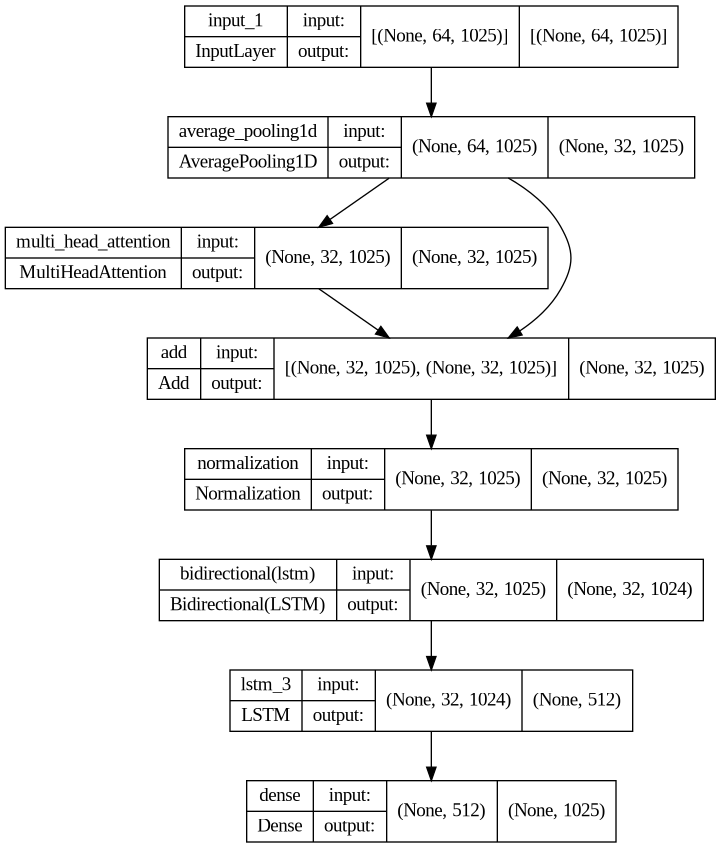

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
losses = model.evaluate(train_ds, return_dict=True)

2022-02-02 01:54:18.840198: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300


91/91 [==============================] - 10s 80ms/step - loss: 0.6934


In [16]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]


In [17]:
%%time
epochs = 5

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)


Epoch 1/5
91/91 [==============================] - 19s 184ms/step - loss: 0.5424
Epoch 2/5
91/91 [==============================] - 17s 190ms/step - loss: 0.5373
Epoch 3/5
91/91 [==============================] - 17s 184ms/step - loss: 0.5373
Epoch 4/5
91/91 [==============================] - 17s 182ms/step - loss: 0.5373
Epoch 5/5
91/91 [==============================] - 17s 189ms/step - loss: 0.5373
CPU times: user 1min 25s, sys: 1.34 s, total: 1min 27s
Wall time: 1min 26s


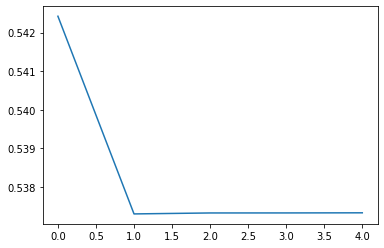

In [18]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [19]:
model.input_shape

(None, 64, 1025)

In [20]:
model.outputs

[<KerasTensor: shape=(None, 1025) dtype=float32 (created by layer 'dense')>]

In [21]:
model.save('model')

2022-02-02 01:56:30.978895: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [22]:
def predict_next(
    inputs: np.ndarray, 
    keras_model: tf.keras.Model, 
    ) -> np.ndarray:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(inputs, 0)
  # random = tf.random.normal(inputs.shape)
  # inputs = inputs * random
  predictions = model.predict(inputs)
  # predictions = inverse_normalization(predictions)
  return predictions


In [23]:
import random

note_start = random.randint(0, len(music_data.T)-seq_length-1)
sample = music_data[:,note_start:note_start+seq_length].T

generated_notes = []

for i in range(num_predictions):
    prediction = predict_next(sample, model)
    generated_notes.append(prediction)
    sample = np.delete(sample, 0, axis=0)
    sample = np.append(sample, prediction, axis=0)
generated_notes = np.concatenate(generated_notes)

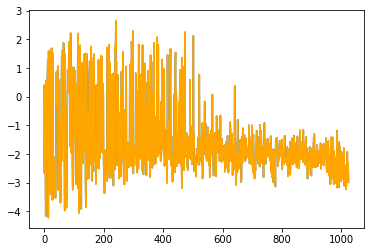

In [24]:
plt.plot(generated_notes[21])
plt.plot(generated_notes[25],color='orange')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

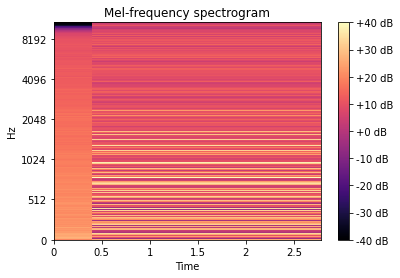

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
generated_notes = normalize(generated_notes) * 80 - 40


# print(generated_notes.min())

img = librosa.display.specshow(generated_notes.T, x_axis='time',

                         y_axis='mel', sr=22050,

                        ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')


In [26]:
import librosa.feature
if config['preprocess']['feature_extraction'] == 'mel':
    A = librosa.feature.inverse.mel_to_audio(generated_notes)
elif config['preprocess']['feature_extraction'] == 'mfcc':
    A = librosa.feature.inverse.mfcc_to_audio(generated_notes)
elif config['preprocess']['feature_extraction'] == 'stft':
    A = librosa.griffinlim(generated_notes)

In [27]:
import IPython.display as ipd
ipd.Audio(A, rate=22050)